In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [47]:
filename = 'sales_predictions.csv'
df = pd.read_csv(filename)
df.head(15) 

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.300,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.920,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.500,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.200,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.930,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052
5,FDP36,10.395,Regular,0.000000,Baking Goods,51.4008,OUT018,2009,Medium,Tier 3,Supermarket Type2,556.6088
6,FDO10,13.650,Regular,0.012741,Snack Foods,57.6588,OUT013,1987,High,Tier 3,Supermarket Type1,343.5528
7,FDP10,NaN,Low Fat,0.127470,Snack Foods,107.7622,OUT027,1985,Medium,Tier 3,Supermarket Type3,4022.7636
8,FDH17,16.200,Regular,0.016687,Frozen Foods,96.9726,OUT045,2002,NaN,Tier 2,Supermarket Type1,1076.5986
9,FDU28,19.200,Regular,0.094450,Frozen Foods,187.8214,OUT017,2007,NaN,Tier 2,Supermarket Type1,4710.5350


In [48]:
df['Item_Fat_Content'].unique()

array(['Low Fat', 'Regular', 'low fat', 'LF', 'reg'], dtype=object)

In [49]:
#Hay que transformar low fat y LF a Low Fat.
#Hay que transformar reg a Regular.
df['Item_Fat_Content'] = df['Item_Fat_Content'].replace('low fat','Low Fat')
df['Item_Fat_Content'] = df['Item_Fat_Content'].replace('LF','Low Fat')
df['Item_Fat_Content'] = df['Item_Fat_Content'].replace('reg','Regular')
df['Item_Fat_Content'].unique()

array(['Low Fat', 'Regular'], dtype=object)

In [50]:
df.shape

(8523, 12)

In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


In [52]:
df.duplicated().sum() #No hay duplicados

0

In [53]:
df.isna().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

Outlet_Size tiene bastantes valores NaN, sin embargo, exisen los Outlet_Identifier, que son la "ID" de los outlet.
De esta manera, podemos conocer el outlet size por medio del outlet identifier.

In [54]:
df['Outlet_Identifier'].unique()

array(['OUT049', 'OUT018', 'OUT010', 'OUT013', 'OUT027', 'OUT045',
       'OUT017', 'OUT046', 'OUT035', 'OUT019'], dtype=object)

In [55]:
df['Outlet_Size'].unique()

array(['Medium', nan, 'High', 'Small'], dtype=object)

In [56]:
df["Outlet_Size"] = df.groupby('Outlet_Type')['Outlet_Size'].transform(lambda x: x.ffill())
#apply
#Outlet_Type
#Outlet size tiene relación con outlet type

In [57]:
df.head(15)

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.300,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.920,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.500,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.200,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.930,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052
5,FDP36,10.395,Regular,0.000000,Baking Goods,51.4008,OUT018,2009,Medium,Tier 3,Supermarket Type2,556.6088
6,FDO10,13.650,Regular,0.012741,Snack Foods,57.6588,OUT013,1987,High,Tier 3,Supermarket Type1,343.5528
7,FDP10,NaN,Low Fat,0.127470,Snack Foods,107.7622,OUT027,1985,Medium,Tier 3,Supermarket Type3,4022.7636
8,FDH17,16.200,Regular,0.016687,Frozen Foods,96.9726,OUT045,2002,High,Tier 2,Supermarket Type1,1076.5986
9,FDU28,19.200,Regular,0.094450,Frozen Foods,187.8214,OUT017,2007,High,Tier 2,Supermarket Type1,4710.5350


De la misma manera, podemos encontrar los valores faltantes en Item_Weight con su identificador Item_Identifier.

In [58]:
df["Item_Weight"] = df.groupby('Item_Identifier')['Item_Weight'].transform(lambda x: x.ffill())

In [59]:
df.head(15)

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.300,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.920,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.500,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.200,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.930,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052
5,FDP36,10.395,Regular,0.000000,Baking Goods,51.4008,OUT018,2009,Medium,Tier 3,Supermarket Type2,556.6088
6,FDO10,13.650,Regular,0.012741,Snack Foods,57.6588,OUT013,1987,High,Tier 3,Supermarket Type1,343.5528
7,FDP10,NaN,Low Fat,0.127470,Snack Foods,107.7622,OUT027,1985,Medium,Tier 3,Supermarket Type3,4022.7636
8,FDH17,16.200,Regular,0.016687,Frozen Foods,96.9726,OUT045,2002,High,Tier 2,Supermarket Type1,1076.5986
9,FDU28,19.200,Regular,0.094450,Frozen Foods,187.8214,OUT017,2007,High,Tier 2,Supermarket Type1,4710.5350


In [60]:
df.isna().sum()

Item_Identifier                0
Item_Weight                  272
Item_Fat_Content               0
Item_Visibility                0
Item_Type                      0
Item_MRP                       0
Outlet_Identifier              0
Outlet_Establishment_Year      0
Outlet_Size                    1
Outlet_Location_Type           0
Outlet_Type                    0
Item_Outlet_Sales              0
dtype: int64

In [61]:
df[df['Outlet_Size'].isna()]

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
3,FDX07,19.2,Regular,0.0,Fruits and Vegetables,182.095,OUT010,1998,NaN,Tier 3,Grocery Store,732.38


In [62]:
df1 = df.loc[df['Outlet_Identifier'] == 'OUT010',]
df1['Outlet_Size'].value_counts()

Small    554
Name: Outlet_Size, dtype: int64

Debido a que todos los valores del identificador OUT010 son Small, reemplazo el valor de Outlet_Size por "Small"

In [63]:
df.loc[3,'Outlet_Size'] = 'Small'
df.isna().sum()

Item_Identifier                0
Item_Weight                  272
Item_Fat_Content               0
Item_Visibility                0
Item_Type                      0
Item_MRP                       0
Outlet_Identifier              0
Outlet_Establishment_Year      0
Outlet_Size                    0
Outlet_Location_Type           0
Outlet_Type                    0
Item_Outlet_Sales              0
dtype: int64

Aún me quedan valores NaN en Item_Weight (272). Debido a que esas 272 filas representan solo un 3.2% del total de los datos, decido eliminarlas.

In [64]:
df.dropna(subset=['Item_Weight'], inplace=True)

In [65]:
df.isna().sum()

Item_Identifier              0
Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
Item_Outlet_Sales            0
dtype: int64

Valor mínimo, valor máximo y media de cada columna numérica

In [66]:
#Mínimo
df.select_dtypes(include=[float, int]).min()

Item_Weight                     4.555
Item_Visibility                 0.000
Item_MRP                       31.490
Outlet_Establishment_Year    1985.000
Item_Outlet_Sales              33.290
dtype: float64

In [67]:
#Máximo
df.select_dtypes(include=[float, int]).max()

Item_Weight                     21.350000
Item_Visibility                  0.328391
Item_MRP                       266.888400
Outlet_Establishment_Year     2009.000000
Item_Outlet_Sales            13086.964800
dtype: float64

In [68]:
#Media
df.select_dtypes(include=[float, int]).mean() 

Item_Weight                    12.879107
Item_Visibility                 0.065828
Item_MRP                      141.154212
Outlet_Establishment_Year    1998.254878
Item_Outlet_Sales            2176.106901
dtype: float64

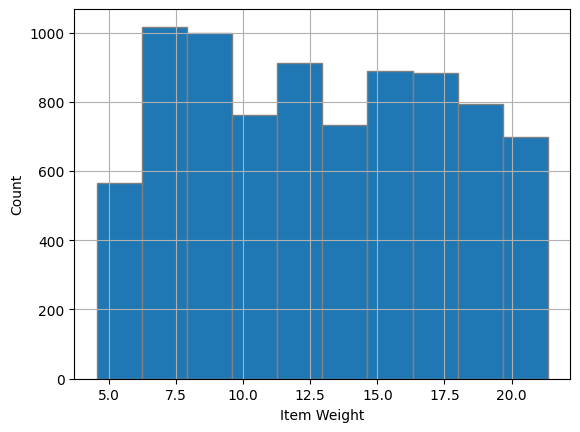

In [69]:
df['Item_Weight'].hist(edgecolor='grey')
plt.xlabel('Item Weight')
plt.ylabel('Count')
plt.show()

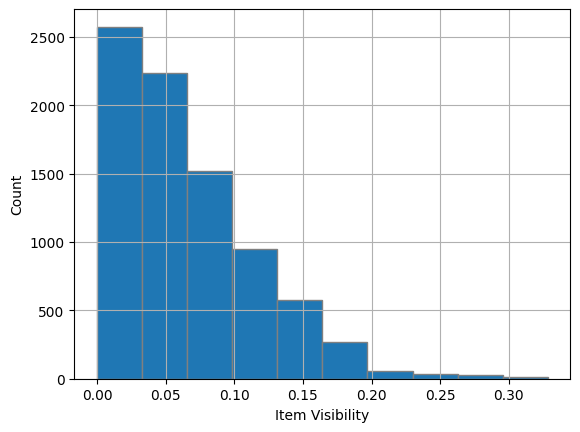

In [70]:
df['Item_Visibility'].hist(edgecolor='grey')
plt.xlabel('Item Visibility')
plt.ylabel('Count')
plt.show()

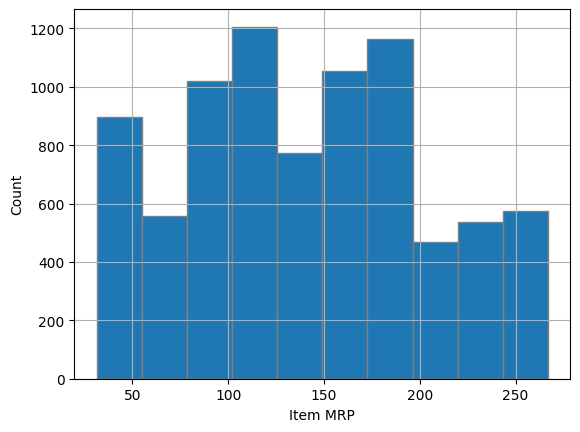

In [71]:
df['Item_MRP'].hist(edgecolor='grey')
plt.xlabel('Item MRP')
plt.ylabel('Count')
plt.show()

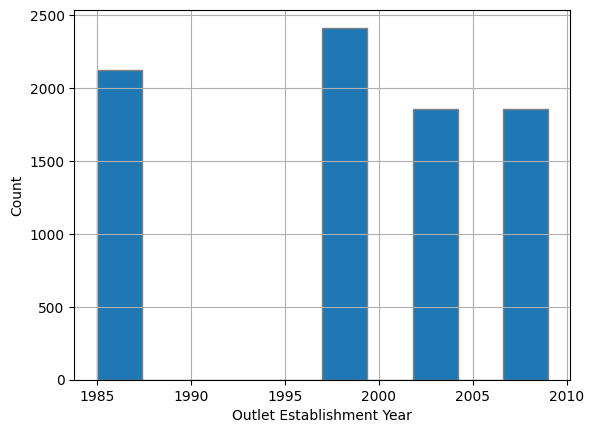

In [72]:
df['Outlet_Establishment_Year'].hist(edgecolor='grey')
plt.xlabel('Outlet Establishment Year')
plt.ylabel('Count')
plt.show()

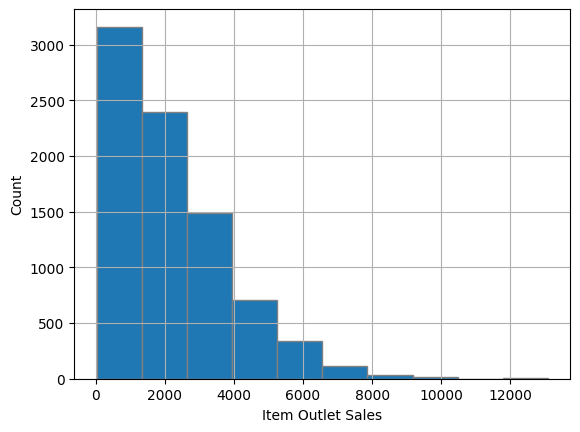

In [73]:
df['Item_Outlet_Sales'].hist(edgecolor='grey')
plt.xlabel('Item Outlet Sales')
plt.ylabel('Count')
plt.show()

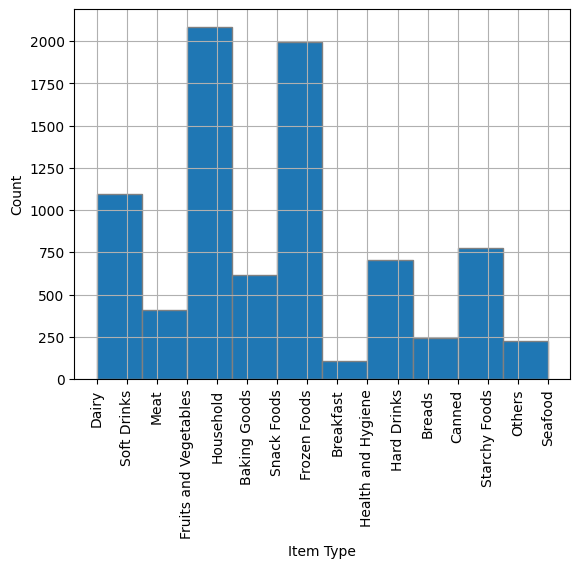

In [74]:
df['Item_Type'].hist(edgecolor='grey')
plt.xlabel('Item Type')
plt.xticks(rotation=90)
plt.ylabel('Count')
plt.show()

Item_Visibility e Item_Outlet_Sales siguen una distribución geométrica.

Los productos más vendidos son frutas y vegetales, junto con comida congelada. Los menos vendidos son productos de desayuno

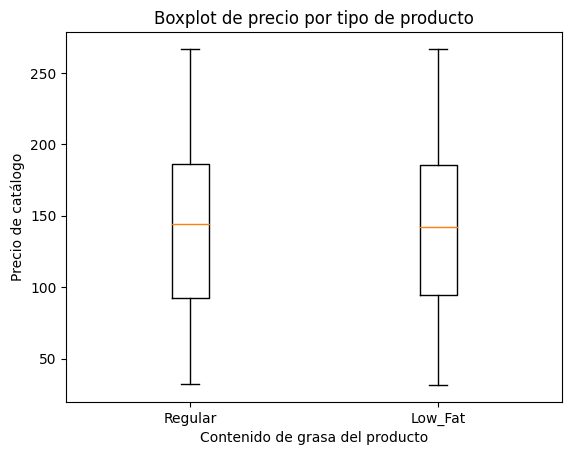

In [75]:
regular = df[df['Item_Fat_Content'] == 'Regular']['Item_MRP']
low_fat = df[df['Item_Fat_Content'] == 'Low Fat']['Item_MRP']

data = [regular, low_fat]

fig, ax = plt.subplots()

ax.boxplot(data)

ax.set_xticklabels(['Regular', 'Low_Fat'])
ax.set_xlabel('Contenido de grasa del producto')
ax.set_ylabel('Precio de catálogo')
ax.set_title('Boxplot de precio por tipo de producto')

plt.show()

Se puede apreciar que no existe mayor diferencia en los precios de los productos bajos en grasas con los productos regulares

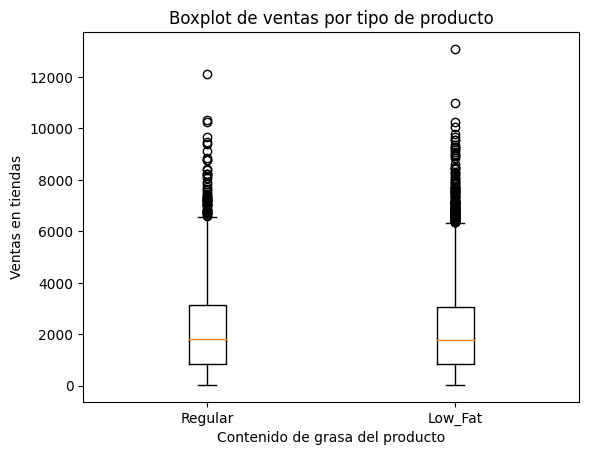

In [76]:
regular = df[df['Item_Fat_Content'] == 'Regular']['Item_Outlet_Sales']
low_fat = df[df['Item_Fat_Content'] == 'Low Fat']['Item_Outlet_Sales']

data = [regular, low_fat]

fig, ax = plt.subplots()

ax.boxplot(data)

ax.set_xticklabels(['Regular', 'Low_Fat'])
ax.set_xlabel('Contenido de grasa del producto')
ax.set_ylabel('Ventas en tiendas')
ax.set_title('Boxplot de ventas por tipo de producto')

plt.show()

Se aprecia que independiente del contenido de grasa del producto, las ventas son casi iguales en las tiendas

C:\Users\fabia\AppData\Local\Temp\ipykernel_11508\2816810641.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()


<AxesSubplot: >

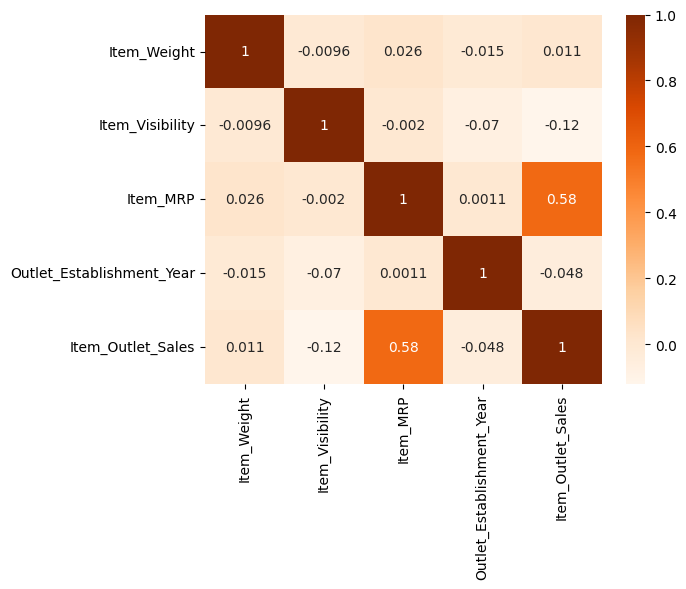

In [77]:
corr = df.corr()
sns.heatmap(corr,cmap='Oranges',annot=True)

Item_MRP e Item_Outlet_Sales presentan una correlación moderada. En cuanto a las otras variables, no se puede identificar ninguna relación.